In [1]:
from keras.datasets import boston_housing

Using TensorFlow backend.


In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [5]:
train_targets[:20]

array([ 15.2,  42.3,  50. ,  21.1,  17.7,  18.5,  11.3,  15.6,  15.6,
        14.4,  12.1,  17.9,  23.1,  19.9,  15.7,   8.8,  50. ,  22.5,
        24.1,  27.5])

In [6]:
train_data.mean(axis=0).shape

(13,)

In [7]:
# Normalizing the data

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [8]:
train_data.shape

(404, 13)

In [9]:
# Model definition

from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [82]:
# K-fold validation

import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]],
                                        axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                         train_targets[(i + 1) * num_val_samples:]],
                                        axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs,
              batch_size=10, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [83]:
all_scores

[2.0618414194277017,
 2.2964676252686149,
 2.4153760093273502,
 2.4416866656577234]

In [84]:
np.mean(all_scores)

2.3038429299203473

In [10]:
# Saving the validation logs at each fold

import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 200
batch_size = 10
all_mae_histories = []
histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]],
                                        axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                         train_targets[(i + 1) * num_val_samples:]],
                                        axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, epochs=num_epochs,
              batch_size=batch_size, verbose=0, validation_data=(val_data, val_targets))
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    histories.append(history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [42]:
[history.history.keys() for history in histories]

[dict_keys(['val_loss', 'val_mean_absolute_error', 'mean_absolute_error', 'loss']),
 dict_keys(['val_loss', 'val_mean_absolute_error', 'mean_absolute_error', 'loss']),
 dict_keys(['val_loss', 'val_mean_absolute_error', 'mean_absolute_error', 'loss']),
 dict_keys(['val_loss', 'val_mean_absolute_error', 'mean_absolute_error', 'loss'])]

In [31]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories])
                           for i in range(num_epochs)]

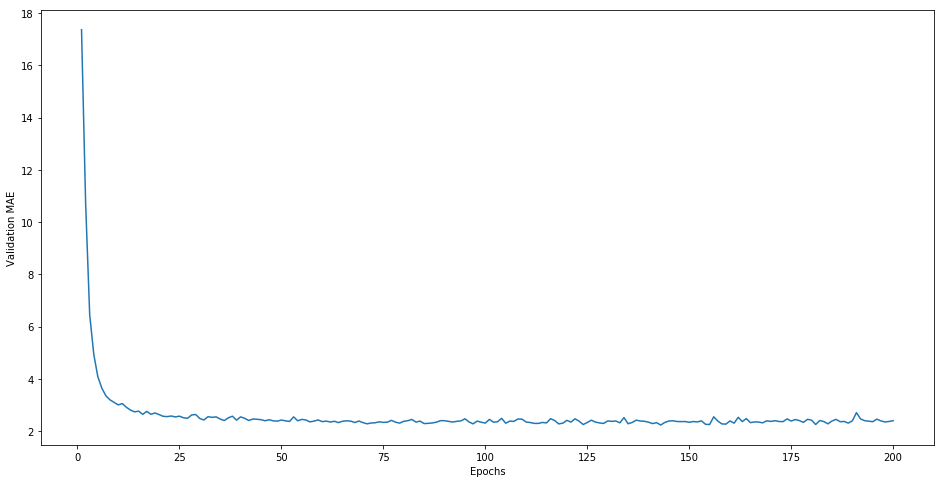

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

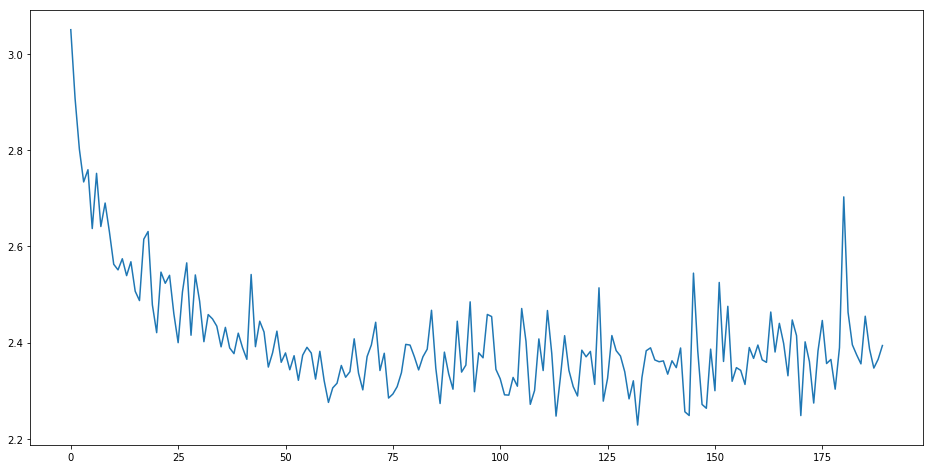

In [13]:
points = np.array(average_mae_history)
plt.plot(points[10:])
# plt.yscale('log')
plt.show()

In [14]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor  + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

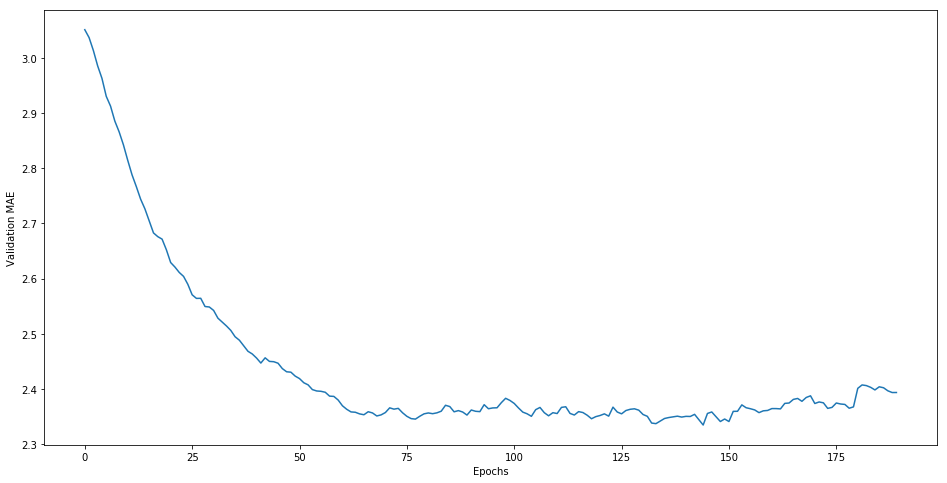

In [15]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


In [16]:
# Training the final model

model = build_model()
history = model.fit(train_data, train_targets,
          epochs=120, batch_size=16, verbose=1)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

Epoch 1/120
404/404 [==============================] - 0s - loss: 474.1034 - mean_absolute_error: 19.7132     
Epoch 2/120
404/404 [==============================] - 0s - loss: 284.2045 - mean_absolute_error: 14.6091     
Epoch 3/120
404/404 [==============================] - 0s - loss: 112.8261 - mean_absolute_error: 8.4651      
Epoch 4/120
404/404 [==============================] - 0s - loss: 43.6141 - mean_absolute_error: 4.9472     
Epoch 5/120
404/404 [==============================] - 0s - loss: 28.7032 - mean_absolute_error: 3.9533     
Epoch 6/120
404/404 [==============================] - 0s - loss: 23.1870 - mean_absolute_error: 3.4736     
Epoch 7/120
404/404 [==============================] - 0s - loss: 20.1164 - mean_absolute_error: 3.2099     
Epoch 8/120
404/404 [==============================] - 0s - loss: 18.1890 - mean_absolute_error: 3.0405     
Epoch 9/120
404/404 [==============================] - 0s - loss: 16.4279 - mean_absolute_error: 2.8621     
Epoch 10/120


404/404 [==============================] - 0s - loss: 5.8940 - mean_absolute_error: 1.7050     
Epoch 76/120
404/404 [==============================] - 0s - loss: 5.9759 - mean_absolute_error: 1.7486     
Epoch 77/120
404/404 [==============================] - 0s - loss: 5.8526 - mean_absolute_error: 1.7271     
Epoch 78/120
404/404 [==============================] - 0s - loss: 5.8623 - mean_absolute_error: 1.7154     
Epoch 79/120
404/404 [==============================] - 0s - loss: 5.8207 - mean_absolute_error: 1.6969     
Epoch 80/120
404/404 [==============================] - 0s - loss: 5.7235 - mean_absolute_error: 1.6864     
Epoch 81/120
404/404 [==============================] - 0s - loss: 5.7433 - mean_absolute_error: 1.6960     
Epoch 82/120
404/404 [==============================] - 0s - loss: 5.3587 - mean_absolute_error: 1.6401     
Epoch 83/120
404/404 [==============================] - 0s - loss: 5.9891 - mean_absolute_error: 1.7544     
Epoch 84/120
404/404 [==========

In [17]:
test_mae_score

2.4537138377918915

## How I'd do it now, easier and best way to do k-fold cross-validation and log results

In [51]:
# Easier K-fold cross-validation   
# Saving the validation logs at each fold
from sklearn.model_selection import KFold
import numpy as np

seed = 7
k = 4
kfold = KFold(n_splits=k)

num_epochs = 200
batch_size = 10
all_mae_histories = []
histories = []

for i, (train, val) in enumerate(kfold.split(train_data, train_targets)):
    print('processing fold #', i)
    partial_train_data = train_data[train]
    partial_train_targets = train_targets[train]
    val_data = train_data[val]
    val_targets = train_targets[val]
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, epochs=num_epochs,
                  batch_size=batch_size, verbose=0, validation_data=(val_data, val_targets))
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    histories.append(history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [59]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

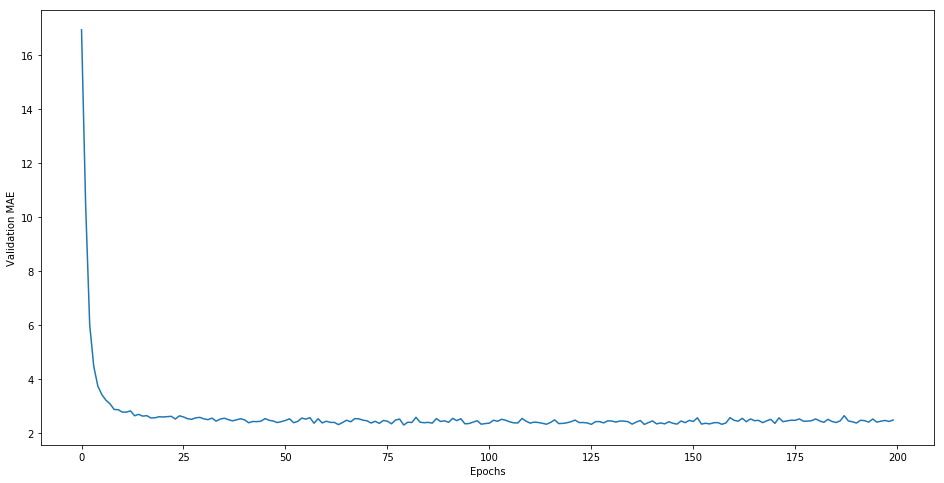

In [63]:
plt.plot(average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()